In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import spatial 
import faiss
import typing
from time import time
import matplotlib.pyplot as plt

# constants
k = 5

## Helper Function

In [2]:
def generate_vectors(
        num_vectors: int,
        dim: int,
        #distribution: str,
        seed: int = 42,
) -> np.ndarray:
    """
    This function generates random vectors of uniform distribution.
    Args:
        num_vectors: The number of vectors to generate.
        dim: The dimensionality of the vectors.
        seed: The random seed.
    Returns:
        An array of shape (num_vectors, dim) containing the generated vectors.
    """
    np.random.seed(seed)
    return np.random.uniform(0, 1, (num_vectors, dim)).astype('float32')

In [3]:
def naive_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray, 
        k: int,
) -> np.ndarray:
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the naive exhaustive approach.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    all_distances = []
    for query_vector in query_vectors:
        query_distances = []
        for index_vector in index_vectors:
            query_distances.append(spatial.distance.euclidean(query_vector, index_vector))
        all_distances.append(np.argsort(query_distances)[:k])
    return np.array(all_distances)

In [4]:
def optimized_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray,
        k: int,
):
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the optimized exhaustive approach implemented in SciPy.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances = spatial.distance.cdist(query_vectors, index_vectors, 'euclidean')
    return np.argsort(distances, axis=1)[:, :k]

In [5]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

In [6]:
def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances, indices = index.search(query_vectors, k)
    return indices

In [7]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

In [8]:
def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

# 1.1 - Running Time Comparison

You are given three methods for vector search:
<ol>
 <li> naive_exhaustive_search </li> 
 <li> optimized_exhaustive_search </li> 
 <li> faiss_flatL2 </li> 
</ol>

each one implements vector search with different levels of optimization. Your task is to compare the running time of these three methods. 
You need to complete the code so that the generated plots should reflect the increasing difference in running time between the methods, as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells between the TODOs, but do not flip the order of the subsections.
When you finish. do not forget to attach the plots to report.pdf, placed under a clear title indicating the section number.

### Generate the following plots:
##### 1.1.1. Running time of the three methods as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
##### 1.1.2. Running time of the three methods as a function of the dimensionality of the vectors (x-axis) with the following parameters fixed:
* number of vectors in the index: 100000
* number of vectors in the query set: 1000

Running for index Size: 10...
Running for index Size: 50...
Running for index Size: 100...
Running for index Size: 250...
Running for index Size: 500...


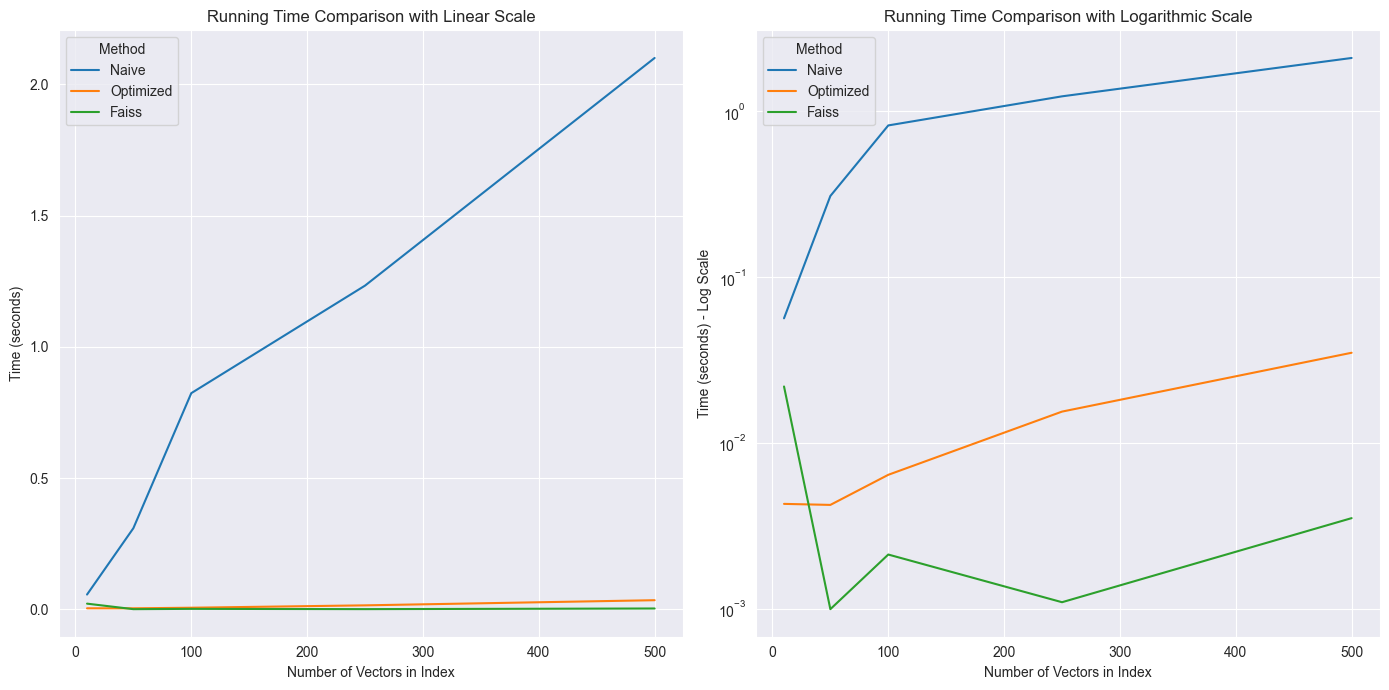

In [9]:
# section 1.1.1
vectors = generate_vectors(1500, 100)
query_vec = vectors[:1000] # first 1000 vectors are query vectors
data_vectors = vectors[1000:] # the rest (500) are the index

index_size = [10, 50, 100, 250, 500]
n_options = len(index_size)
naive_runtime1 = []
optim_runtime1 = []
faiss_runtime1 = []

for size in index_size:
    print(f'Running for index Size: {size}...')
    cur_index = data_vectors[:size]
    flat_index = build_faiss_flatl2_index(data_vectors[:size], 100)
    
    start_time = time()
    _ = naive_exhaustive_search(query_vec, cur_index, k)
    end_time = time() - start_time
    naive_runtime1.append(end_time)
    
    start_time = time()
    _ = optimized_exhaustive_search(query_vec, cur_index, k)
    end_time = time() - start_time
    optim_runtime1.append(end_time)
    
    start_time = time()
    _ = faiss_search(query_vec, flat_index, k)
    end_time = time() - start_time
    faiss_runtime1.append(end_time)
    
# # plotting
# data1 = {
#     'Number of Vectors in Index': index_size * 3,
#     'Time (seconds)': naive_runtime1 + optim_runtime1 + faiss_runtime1, 
#     'Method': ['Naive'] * n_options + ['Optimized'] * n_options + ['Faiss'] * n_options
# }
# df1 = pd.DataFrame(data1)
# plt.figure()
# sns.lineplot(x='Number of Vectors in Index', y='Time (seconds)', hue='Method', data=df1)
# plt.yscale('log')
# plt.ylabel('Time (seconds) - Log Scale')
# plt.title('Running Time Comparison of search methods per Index Size')
# plt.show()

data1 = {
    'Number of Vectors in Index': index_size * 3, 
    'Time (seconds)': naive_runtime1 + optim_runtime1 + faiss_runtime1, 
    'Method': ['Naive'] * n_options + ['Optimized'] * n_options + ['Faiss'] * n_options 
}
df1 = pd.DataFrame(data1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot on the first subplot with linear y-scale
sns.lineplot(ax=axes[0], x='Number of Vectors in Index', y='Time (seconds)', hue='Method', data=df1)
axes[0].set_ylabel('Time (seconds)')
axes[0].set_title('Running Time Comparison with Linear Scale')

# Plot on the second subplot with logarithmic y-scale
sns.lineplot(ax=axes[1], x='Number of Vectors in Index', y='Time (seconds)', hue='Method', data=df1)
axes[1].set_yscale('log')
axes[1].set_ylabel('Time (seconds) - Log Scale')
axes[1].set_title('Running Time Comparison with Logarithmic Scale')

# Set a common x-label
for ax in axes:
    ax.set_xlabel('Number of Vectors in Index')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

Running for dimension: 10...
Running for dimension: 50...
Running for dimension: 100...
Running for dimension: 250...
Running for dimension: 500...


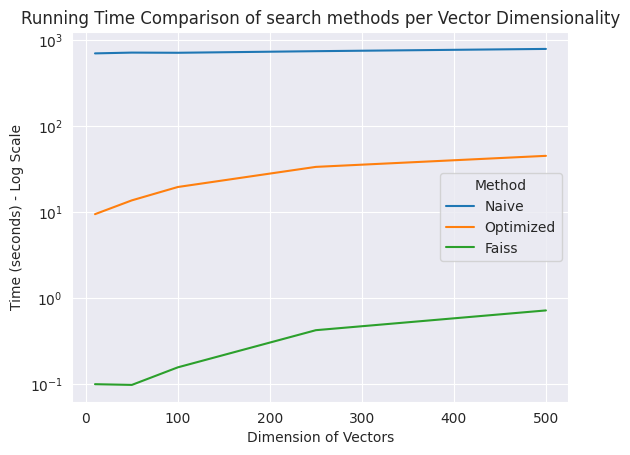

In [20]:
# section 1.1.2
dims = [10, 50, 100, 250, 500]
naive_runtime2 = []
optim_runtime2 = []
faiss_runtime2 = []

for dim in dims:
    curr_vectors = generate_vectors(101000, dim)
    curr_query_vec = curr_vectors[:1000]
    curr_data_vectors = curr_vectors[1000:]
    curr_flat_index = build_faiss_flatl2_index(curr_data_vectors, dim)
    
    print(f'Running for dimension: {dim}...')
    
    start_time = time()
    _ = naive_exhaustive_search(curr_query_vec, curr_data_vectors, k)
    end_time = time() - start_time
    naive_runtime2.append(end_time)
    
    start_time = time()
    _ = optimized_exhaustive_search(curr_query_vec, curr_data_vectors, k)
    end_time = time() - start_time
    optim_runtime2.append(end_time)
    
    start_time = time()
    _ = faiss_search(curr_query_vec, curr_flat_index, k)
    end_time = time() - start_time
    faiss_runtime2.append(end_time)
    
    
# plotting
data2 = {
    'Dimension of Vectors': dims * 3,
    'Time (seconds)': naive_runtime2 + optim_runtime2 + faiss_runtime2, 
    'Method': ['Naive'] * n_options + ['Optimized'] * n_options + ['Faiss'] * n_options
}
df2 = pd.DataFrame(data2)
plt.figure()
sns.lineplot(x='Dimension of Vectors', y='Time (seconds)', hue='Method', data=df2)
plt.yscale('log')
plt.ylabel('Time (seconds) - Log Scale')
plt.title('Running Time Comparison of search methods per Vector Dimensionality')
plt.show()

In [ ]:
# import torch
# 
# def naive_exhaustive_search_gpu(
#         query_vectors: np.ndarray,
#         index_vectors: np.ndarray,
#         k: int,
# ) -> np.ndarray:
#     """
#     This function computes the k-nearest neighbors of query_vectors in index_vectors using the naive exhaustive approach.
#     Args:
#         query_vectors: An array of shape (n_queries, dim) containing the query vectors.
#         index_vectors: An array of shape (n_index, dim) containing the index vectors.
#         k: The number of nearest neighbors to retrieve.
#     Returns:
#         An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
#     """
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 
#     query_vectors = torch.from_numpy(query_vectors).to(device)
#     index_vectors = torch.from_numpy(index_vectors).to(device)
# 
#     all_distances = []
#     for query_vector in query_vectors:
#         query_distances = []
#         for index_vector in index_vectors:
#             query_distances.append(torch.dist(query_vector, index_vector).item())
#         all_distances.append(torch.argsort(torch.tensor(query_distances))[:k].cpu().numpy())
#     return np.array(all_distances)

# 1.2 -- Faiss LSH
### Create the following plots:
##### 1.2.1. Running time of Faiss LSH as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* nbits: 500

##### 1.2.2. Running time of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* number of vectors in the index: 500000


##### 1.2.3. recall@k of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* number of vectors in the index: 500000
* k: 10


You need to complete the code so that the generated plots should reflect the desired metrics as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells between the TODOs, but do not flip the order of the subsections.
When you finish. do not forget to attach the plots to report.pdf, placed under a clear title indicating the section number.


Running for index Size: 10...
Running for index Size: 50...
Running for index Size: 100...
Running for index Size: 250...
Running for index Size: 500...


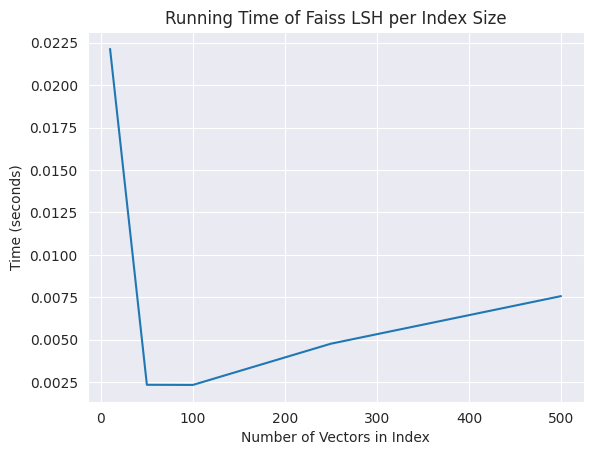

In [17]:
# section 1.2.1
vectors = generate_vectors(1500, 100)
query_vec = vectors[:1000] # first 1000 vectors are query vectors
data_vectors = vectors[1000:] # the rest (500) are the index

index_size = [10, 50, 100, 250, 500]
faiss_runtime3 = []

for size in index_size:
    print(f'Running for index Size: {size}...')
    cur_index = data_vectors[:size]
    lsh_index = build_faiss_lsh_index(data_vectors[:size], 100, 500)
    start_time = time()
    _ = faiss_search(query_vec, lsh_index, k)
    end_time = time() - start_time
    faiss_runtime3.append(end_time)
    
# plotting
data3 = {
    'Number of Vectors in Index': index_size,
    'Time (seconds)': faiss_runtime3
}
df3 = pd.DataFrame(data3)
plt.figure()
sns.lineplot(x='Number of Vectors in Index', y='Time (seconds)', data=df3)
plt.title('Running Time of Faiss LSH per Index Size')
plt.show()

Running for nbits value: 100...
Running for nbits value: 250...
Running for nbits value: 500...
Running for nbits value: 750...
Running for nbits value: 1000...


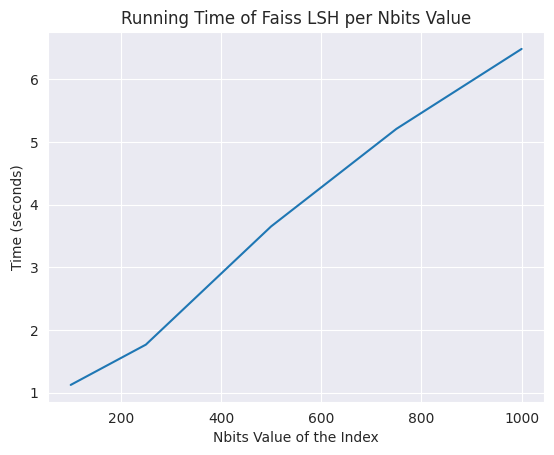

In [18]:
# section 1.2.2
vectors = generate_vectors(501000, 100)
query_vec = vectors[:1000] # first 1000 vectors are query vectors
data_vectors = vectors[1000:] # the rest (50000) are the index

nbits_options = [100, 250, 500, 750, 1000]
faiss_runtime4 = []

for nbit in nbits_options:
    print(f'Running for nbits value: {nbit}...')
    lsh_index = build_faiss_lsh_index(data_vectors, 100, nbit)
    start_time = time()
    _ = faiss_search(query_vec, lsh_index, k)
    end_time = time() - start_time
    faiss_runtime4.append(end_time)
    
# plotting
data4 = {
    'Nbits Value of the Index': nbits_options,
    'Time (seconds)': faiss_runtime4
}
df4 = pd.DataFrame(data4)
plt.figure()
sns.lineplot(x='Nbits Value of the Index', y='Time (seconds)', data=df4)
plt.title('Running Time of Faiss LSH per Nbits Value')
plt.show()

Finished ground truth search...
Running for nbits value: 100...
Running for nbits value: 250...
Running for nbits value: 500...
Running for nbits value: 750...
Running for nbits value: 1000...


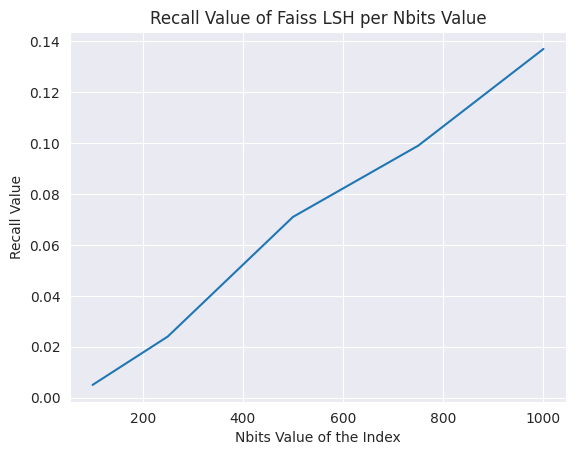

In [19]:
# section 1.2.3
fixed_k = 10
vectors = generate_vectors(501000, 100)
query_vec = vectors[:1000] # first 1000 vectors are query vectors
data_vectors = vectors[1000:] # the rest (50000) are the index
gt_neighbors = optimized_exhaustive_search(query_vec, data_vectors, fixed_k)
print(f'Finished ground truth search...')

nbits_options = [100, 250, 500, 750, 1000]
faiss_recall = []
for nbit in nbits_options:
    print(f'Running for nbits value: {nbit}...')
    lsh_index = build_faiss_lsh_index(data_vectors, 100, nbit)
    curr_faiss_res = faiss_search(query_vec, lsh_index, fixed_k)
    curr_recall = compute_recall_at_k(gt_neighbors, curr_faiss_res, fixed_k)
    faiss_recall.append(curr_recall)
    
# plotting
data5 = {
    'Nbits Value of the Index': nbits_options,
    'Recall Value': faiss_recall
}
df5 = pd.DataFrame(data5)
plt.figure()
sns.lineplot(x='Nbits Value of the Index', y='Recall Value', data=df5)
plt.title('Recall@10 Value of Faiss LSH per Nbits Value')
plt.show()